In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [245]:

class CustomData(object):

    def __init__(self, root, id_file, cls=None):
        """
        :param root: 包含所有病人文件夹的根文件夹路径
        :param id_file: 包含所有病人id的csv文件路径
        :param cls: 病人分类，0或1
        """
        super().__init__()
        self.root = root
        if cls is not None:
            ds = pd.read_csv(id_file, header=0)
            self.all_pid = ds.loc[ds.iloc[:,1]==cls, "HADM_ID"].tolist()
            print("all_pid 的数量:", len(self.all_pid))
        else:
            ds = pd.read_csv(id_file, header=0)
            self.all_pid = ds.loc[:, "HADM_ID"].tolist()
            print("all_pid 的数量:", len(self.all_pid))

    def __len__(self):
        return len(self.all_pid)
    
    def len(self):
        return len(self.all_pid)

    def get_item(self, ind):

        folder_path = os.path.join(self.root, str(self.all_pid[ind]))

        dym_X_locf = pd.read_csv(os.path.join(folder_path, "dym_X_locf.csv"), header=0)
        X_dym = np.asarray(dym_X_locf)

        static_vars = ["AGE","Aids", "Hm", "Mc", "ADtype1", "ADtype2","ADtype3"]
        full = pd.read_csv(os.path.join(folder_path, "full.csv"), header=0)
        time = np.asarray(full.loc[:,"time"]).reshape(-1,1)
        y = np.asarray(full.loc[:,"HOSPITAL_EXPIRE_FLAG"]).reshape(-1,1)
        X_stc = np.asarray(full.loc[:,static_vars])
        
        mask_fea = pd.read_csv(os.path.join(folder_path, "mask_fea.csv"), header=0)
        mask_fea = np.asarray(mask_fea)
        
        mask = pd.read_csv(os.path.join(folder_path, "mask.csv"), header=0)
        mask = np.asarray(mask)

        return X_dym, X_stc, mask_fea, time, y, mask

    def get_item1(self, ind):

        datas = self.get_item(ind)
        if datas is not None:
            X_dym, X_stc, mask_fea, time, y, mask = datas
        else:
            return None

        X_dym = torch.from_numpy(X_dym).float()
        X_stc = torch.from_numpy(X_stc).float()
        mask_fea = torch.from_numpy(mask_fea).float()
        time = torch.from_numpy(time).float()
        y = torch.from_numpy(y).float()
        mask = torch.from_numpy(mask).float()
        
        return X_dym, X_stc, mask_fea, time, y, mask


    def get_data(self, inds):

        batches = []
        ids1 = []
        for i in range(len(inds)):
            data = self.get_item1(inds[i])
            if data is None:
                continue
            else:
                batches.append(data)
                ids1.append(inds[i])
        return batches, ids1

    def iterate_batch(self, size, shuffle=True):

        if size > self.len():
            raise ValueError("batch size 大于了总样本数")

        if shuffle:
            all_ids = np.random.choice(self.len(), size=self.len(), replace=False)
        else:
            all_ids = list(range(self.len()))

        if self.len() % size == 0:
            n = self.len() // size
        else:
            n = self.len() // size + 1

        for i in range(n):
            if i == n:
                yield self.get_data(all_ids[(size * i):])
            else:
                yield self.get_data(all_ids[(size * i): (size * (i + 1))])
        return

In [246]:
class PredModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PredModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        out = F.sigmoid(out)
        return out

In [247]:
data_pos = CustomData("/home/luojiawei/mimic3_Miss_project/all_admissions/",
                      "/home/luojiawei/mimic3_Miss_project/train.csv",
                     cls=1)

data_neg = CustomData("/home/luojiawei/mimic3_Miss_project/all_admissions/",
                      "/home/luojiawei/mimic3_Miss_project/train.csv",
                     cls=0)

data_valid = CustomData("/home/luojiawei/mimic3_Miss_project/all_admissions/",
                      "/home/luojiawei/mimic3_Miss_project/valid.csv")

all_pid 的数量: 1843
all_pid 的数量: 15051
all_pid 的数量: 2817


In [248]:
model = PredModel(input_size=21, hidden_size=200, num_layers=2, output_size=1)

In [244]:
model.load_state_dict(torch.load("/home/luojiawei/mimic3_Miss_project/pred_model_params-1.pth"))

<All keys matched successfully>

In [249]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [250]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [251]:
model = model.to(device)

In [252]:

batch_size = 200
best_loss = float('inf')
no_improvement_count = 0
for epoch in range(100):
    running_loss = 0.0
    data_pos_loader = data_pos.iterate_batch(200)
    data_neg_loader = data_neg.iterate_batch(200)
    
    while True:
        try:
            data_batch_pos, ids_pos = next(data_pos_loader)
            data_batch_neg, ids_neg = next(data_neg_loader)
        except StopIteration:
            break
        
        if len(ids_neg) < len(ids_pos):
            break

        running_loss = 0.0
        loss = 0.0

        for i in tqdm(range(len(data_batch_pos))):
            X_dym_pos, X_stc_pos, mask_fea_pos, time_pos, y_pos, mask_pos = data_batch_pos[i]
            X_dym_neg, X_stc_neg, mask_fea_neg, time_neg, y_neg, mask_neg = data_batch_neg[i]
            
            X_pos = torch.cat([X_dym_pos, X_stc_pos], dim=1)
            X_neg = torch.cat([X_dym_neg, X_stc_neg], dim=1)

            # 如果X_pos或X_neg的行大于12,则取前12行,否则取所有行
            # 这里的12表示前48小时
            if X_pos.shape[0] > 12:
                X_pos = X_pos[:12,:]
            if X_neg.shape[0] > 12:
                X_neg = X_neg[:12,:]

            # X_pos 现在的维度是 time*d , time是行数， d是变量数，我想把它变成 1*time*d，然后输入到model里面
            X_pos = X_pos.view(1, -1, X_pos.shape[-1]).to(device)
            out_pos = model(X_pos)
            
            X_neg = X_neg.view(1, -1, X_neg.shape[-1]).to(device)
            out_neg = model(X_neg)

            # y_pos 和 y_neg 的 shape 都是 time*1
            loss += F.binary_cross_entropy(out_pos, y_pos[-1].view(-1,1).to(device)) + F.binary_cross_entropy(out_neg, y_neg[-1].view(-1,1).to(device))
        
        loss /= (len(data_batch_pos) * batch_size)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == len(data_batch_pos)-1:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, i, running_loss))

    # 每轮 epoch 完了以后评估测试集表现，若 valid_loss 有改善，则保存模型参数
    # 若连续两轮 valid_loss 都没有改善，则终止训练
    # 在每轮 epoch 完成后，计算测试集上的 loss
    with torch.no_grad():
        valid_loss = 0.0
        data_valid_loader = data_valid.iterate_batch(200)
        while True:
            try:
                data_batch_valid, ids_valid = next(data_valid_loader)
            except StopIteration:
                break

            for i in range(len(data_batch_valid)):
                X_dym_valid, X_stc_valid, mask_fea_valid, time_valid, y_valid, mask_valid = data_batch_valid[i]
                X_valid = torch.cat([X_dym_valid, X_stc_valid], dim=1)
                if X_valid.shape[0] > 12:
                    X_valid = X_valid[:12,:]
                X_valid = X_valid.view(1, -1, X_valid.shape[-1]).to(device)
                out_valid = model(X_valid)
                valid_loss += F.binary_cross_entropy(out_valid, y_valid[-1].view(-1,1).to(device)).item()

        valid_loss /= data_valid.len()
        # print valid_loss
        print("Valid loss: {}".format(valid_loss))
        # 如果 valid_loss 有改善，则保存模型参数
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), "/home/luojiawei/mimic3_Miss_project/pred_model_params-1.pth")
            no_improvement_count = 0
            print("参数已更新")
        else:
            no_improvement_count += 1
        
        # 若连续两轮 valid_loss 都没有改善，则终止训练
        if no_improvement_count == 2:
            break


  0%|          | 0/200 [00:00<?, ?it/s]/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 200/200 [00:01<00:00, 148.34it/s]


Epoch: 0, Batch: 199, Loss: 0.006913648918271065


100%|██████████| 200/200 [00:00<00:00, 207.23it/s]


Epoch: 0, Batch: 199, Loss: 0.006688281893730164


100%|██████████| 200/200 [00:00<00:00, 202.30it/s]


Epoch: 0, Batch: 199, Loss: 0.006575699429959059


100%|██████████| 200/200 [00:01<00:00, 194.98it/s]


Epoch: 0, Batch: 199, Loss: 0.00642834696918726


100%|██████████| 200/200 [00:00<00:00, 208.83it/s]


Epoch: 0, Batch: 199, Loss: 0.005970758851617575


100%|██████████| 200/200 [00:01<00:00, 193.80it/s]


Epoch: 0, Batch: 199, Loss: 0.006028877571225166


100%|██████████| 200/200 [00:00<00:00, 210.32it/s]


Epoch: 0, Batch: 199, Loss: 0.0062317019328475


100%|██████████| 200/200 [00:01<00:00, 196.92it/s]


Epoch: 0, Batch: 199, Loss: 0.00578660424798727


100%|██████████| 200/200 [00:01<00:00, 199.48it/s]


Epoch: 0, Batch: 199, Loss: 0.005371426697820425


100%|██████████| 43/43 [00:00<00:00, 171.53it/s]


Epoch: 0, Batch: 42, Loss: 0.0053558493964374065
Valid loss: 0.6931702162571883
参数已更新


100%|██████████| 200/200 [00:01<00:00, 197.22it/s]


Epoch: 1, Batch: 199, Loss: 0.005814877804368734


100%|██████████| 200/200 [00:00<00:00, 205.26it/s]


Epoch: 1, Batch: 199, Loss: 0.005371573846787214


100%|██████████| 200/200 [00:01<00:00, 194.22it/s]


Epoch: 1, Batch: 199, Loss: 0.005592477507889271


100%|██████████| 200/200 [00:00<00:00, 201.18it/s]


Epoch: 1, Batch: 199, Loss: 0.005359829403460026


100%|██████████| 200/200 [00:01<00:00, 199.60it/s]


Epoch: 1, Batch: 199, Loss: 0.005939070135354996


100%|██████████| 200/200 [00:00<00:00, 205.48it/s]


Epoch: 1, Batch: 199, Loss: 0.005238463170826435


100%|██████████| 200/200 [00:01<00:00, 199.52it/s]


Epoch: 1, Batch: 199, Loss: 0.005569437053054571


100%|██████████| 200/200 [00:00<00:00, 201.34it/s]


Epoch: 1, Batch: 199, Loss: 0.005571415182203054


100%|██████████| 200/200 [00:00<00:00, 203.90it/s]


Epoch: 1, Batch: 199, Loss: 0.005437855608761311


100%|██████████| 43/43 [00:00<00:00, 213.03it/s]


Epoch: 1, Batch: 42, Loss: 0.005544646177440882
Valid loss: 0.75528315991761


100%|██████████| 200/200 [00:01<00:00, 194.44it/s]


Epoch: 2, Batch: 199, Loss: 0.005643174052238464


100%|██████████| 200/200 [00:00<00:00, 200.99it/s]


Epoch: 2, Batch: 199, Loss: 0.005248140078037977


100%|██████████| 200/200 [00:01<00:00, 198.35it/s]


Epoch: 2, Batch: 199, Loss: 0.004954725969582796


100%|██████████| 200/200 [00:00<00:00, 216.01it/s]


Epoch: 2, Batch: 199, Loss: 0.005493034143000841


100%|██████████| 200/200 [00:01<00:00, 199.23it/s]


Epoch: 2, Batch: 199, Loss: 0.004799737129360437


100%|██████████| 200/200 [00:01<00:00, 194.73it/s]


Epoch: 2, Batch: 199, Loss: 0.005247363355010748


100%|██████████| 200/200 [00:00<00:00, 204.16it/s]


Epoch: 2, Batch: 199, Loss: 0.004873551893979311


100%|██████████| 200/200 [00:01<00:00, 185.85it/s]


Epoch: 2, Batch: 199, Loss: 0.005334476009011269


100%|██████████| 200/200 [00:00<00:00, 202.98it/s]


Epoch: 2, Batch: 199, Loss: 0.005165142938494682


100%|██████████| 43/43 [00:00<00:00, 186.72it/s]


Epoch: 2, Batch: 42, Loss: 0.005281385965645313
Valid loss: 0.4654477748981511
参数已更新


100%|██████████| 200/200 [00:01<00:00, 192.93it/s]


Epoch: 3, Batch: 199, Loss: 0.004983683116734028


100%|██████████| 200/200 [00:01<00:00, 198.87it/s]


Epoch: 3, Batch: 199, Loss: 0.004851889796555042


100%|██████████| 200/200 [00:01<00:00, 192.52it/s]


Epoch: 3, Batch: 199, Loss: 0.005163493100553751


100%|██████████| 200/200 [00:00<00:00, 200.28it/s]


Epoch: 3, Batch: 199, Loss: 0.0049022892490029335


100%|██████████| 200/200 [00:00<00:00, 204.15it/s]


Epoch: 3, Batch: 199, Loss: 0.004739087540656328


100%|██████████| 200/200 [00:01<00:00, 198.57it/s]


Epoch: 3, Batch: 199, Loss: 0.004941940773278475


100%|██████████| 200/200 [00:00<00:00, 203.00it/s]


Epoch: 3, Batch: 199, Loss: 0.005368104670196772


100%|██████████| 200/200 [00:00<00:00, 201.14it/s]


Epoch: 3, Batch: 199, Loss: 0.004901255946606398


100%|██████████| 200/200 [00:00<00:00, 203.07it/s]


Epoch: 3, Batch: 199, Loss: 0.005061945412307978


100%|██████████| 43/43 [00:00<00:00, 186.16it/s]


Epoch: 3, Batch: 42, Loss: 0.005587710067629814
Valid loss: 0.4270715136431425
参数已更新


100%|██████████| 200/200 [00:00<00:00, 200.85it/s]


Epoch: 4, Batch: 199, Loss: 0.005048566963523626


100%|██████████| 200/200 [00:00<00:00, 203.14it/s]


Epoch: 4, Batch: 199, Loss: 0.0054165939800441265


100%|██████████| 200/200 [00:00<00:00, 210.69it/s]


Epoch: 4, Batch: 199, Loss: 0.005001935642212629


100%|██████████| 200/200 [00:00<00:00, 206.52it/s]


Epoch: 4, Batch: 199, Loss: 0.005048829596489668


100%|██████████| 200/200 [00:01<00:00, 198.65it/s]


Epoch: 4, Batch: 199, Loss: 0.0051002888940274715


100%|██████████| 200/200 [00:01<00:00, 194.17it/s]


Epoch: 4, Batch: 199, Loss: 0.004790633451193571


100%|██████████| 200/200 [00:01<00:00, 195.82it/s]


Epoch: 4, Batch: 199, Loss: 0.004778464790433645


100%|██████████| 200/200 [00:01<00:00, 192.67it/s]


Epoch: 4, Batch: 199, Loss: 0.004758964758366346


100%|██████████| 200/200 [00:00<00:00, 200.86it/s]


Epoch: 4, Batch: 199, Loss: 0.004788212012499571


100%|██████████| 43/43 [00:00<00:00, 193.67it/s]


Epoch: 4, Batch: 42, Loss: 0.005661500617861748
Valid loss: 0.4375079472753906


100%|██████████| 200/200 [00:00<00:00, 201.13it/s]


Epoch: 5, Batch: 199, Loss: 0.004477154463529587


100%|██████████| 200/200 [00:01<00:00, 195.50it/s]


Epoch: 5, Batch: 199, Loss: 0.004732909612357616


100%|██████████| 200/200 [00:01<00:00, 194.44it/s]


Epoch: 5, Batch: 199, Loss: 0.0045856935903429985


100%|██████████| 200/200 [00:00<00:00, 201.95it/s]


Epoch: 5, Batch: 199, Loss: 0.004979118704795837


100%|██████████| 200/200 [00:01<00:00, 191.56it/s]


Epoch: 5, Batch: 199, Loss: 0.004447133745998144


100%|██████████| 200/200 [00:01<00:00, 192.62it/s]


Epoch: 5, Batch: 199, Loss: 0.004732709843665361


100%|██████████| 200/200 [00:00<00:00, 207.32it/s]


Epoch: 5, Batch: 199, Loss: 0.004663839470595121


100%|██████████| 200/200 [00:00<00:00, 209.79it/s]


Epoch: 5, Batch: 199, Loss: 0.004398093558847904


100%|██████████| 200/200 [00:01<00:00, 199.07it/s]


Epoch: 5, Batch: 199, Loss: 0.004558450076729059


100%|██████████| 43/43 [00:00<00:00, 193.89it/s]


Epoch: 5, Batch: 42, Loss: 0.005144538823515177
Valid loss: 0.438696294620284


In [278]:
model = PredModel(input_size=21, hidden_size=200, num_layers=2, output_size=1)
model.load_state_dict(torch.load("/home/luojiawei/mimic3_Miss_project/pred_model_params-1-b.pth"))
model = model.to(device)
model = model.eval()

In [279]:
data = CustomData("/home/luojiawei/mimic3_Miss_project/all_admissions/",
                      "/home/luojiawei/mimic3_Miss_project/train.csv")

all_pid 的数量: 16894


In [280]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.metrics import roc_curve

In [281]:
# 初始化两个空列表，用于保存每个样本的真实标签和预测标签
y_true_total = []
y_pred_total = []

# 初始化一个空列表，用于保存 每个样本的 hadm_id
hadm_id_list = []

#加一个进度条，让我能看见进
for i in tqdm(range(data.len())):    
    
    # 取出 样本i 的数据，用get_item1方法     
    X_dym, X_stc, mask_fea, time, y, mask = data.get_item1(i)
    hadm_id_list.append(data.all_pid[i])
    X = torch.cat([X_dym, X_stc], dim=1)
    # 如果X_pos或X_neg的行大于12,则取前12行,否则取所有行
    # 这里的12表示前48小时
    if X.shape[0] > 12:
        X = X[:12,:]
    
    X = X.view(1, -1, X.shape[-1]).to(device)
    out = model(X)

    y_true_total.append(y[-1].item())
    y_pred_total.append(out.item())


  0%|          | 0/16894 [00:00<?, ?it/s]/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 16894/16894 [06:03<00:00, 46.47it/s]


In [282]:
import pandas as pd

In [283]:
base_info_test = pd.read_csv("/home/luojiawei/mimic3_Miss_project/train.csv", header=0)

In [284]:
print("类别数量:", len(set(base_info_test['cluster'])))

KeyError: 'cluster'

In [285]:
base_info_test.head()

,HADM_ID,HOSPITAL_EXPIRE_FLAG,death_within_28d,death_within_90d
0,142735,1,1,1
1,145545,0,0,1
2,122311,0,0,0
3,132895,0,0,1
4,120073,1,1,1


In [293]:
# base_info_test 有三列，第一列是 HADM_ID,第二列是 HOSPITAL_EXPIRE_FLAG, 第三列是cluster，
# 我想将 y_ture和y_pred 与 base_info_test merge成一个 dataframe
result = pd.DataFrame({'HADM_ID': hadm_id_list, 'death_within_90d': y_true_total, 'PREDICTION': y_pred_total})

In [294]:
result = pd.merge(result, base_info_test, on='HADM_ID')

In [295]:
result.head()

,HADM_ID,death_within_90d_x,PREDICTION,HOSPITAL_EXPIRE_FLAG,death_within_28d,death_within_90d_y
0,142735,1.0,0.515595,1,1,1
1,145545,0.0,0.346989,0,0,1
2,122311,0.0,0.037119,0,0,0
3,132895,0.0,0.357587,0,0,1
4,120073,1.0,0.120299,1,1,1


In [296]:
# 把result 输出到csv文件
result.to_csv("/home/luojiawei/mimic3_Miss_project/result_train-1-b.csv", index=False)

In [157]:
# 先查看一共有多少类别
print("类别数量:", len(set(result['cluster'])))

类别数量: 5


In [242]:
# 对result中的所有样本计算 auroc,利用bootstrap发计算标准差和置信区间
auroc_total = roc_auc_score(result['HOSPITAL_EXPIRE_FLAG_y'], result['PREDICTION'])
auroc_list = []
for i in range(200):
    resampled = result.sample(frac=1, replace=True)
    auroc_resampled = roc_auc_score(resampled['HOSPITAL_EXPIRE_FLAG_y'], resampled['PREDICTION'])
    auroc_list.append(auroc_resampled)
auroc_std_total = np.std(auroc_list)
auroc_ci_total = np.percentile(y_pred_total, [2.5, 97.5])
print("AUROC 95% CI:", auroc_ci_total)
print("AUROC:", auroc_total)
print("AUROC std:", auroc_std_total)

AUROC 95% CI: [0.05730227 0.92495937]
AUROC: 0.8180581624141282
AUROC std: 0.004743974341256629


In [159]:
# 对每个类别计算 结果的 auroc ，利用bootstrap法计算标准差和置信区间
# 将每个类的结果保存起来，方便后面绘制ROC图，和置信区间的森林图
auroc_dict = {}
for cls in set(result['cluster']):
    y_true_cls = result.loc[result['cluster']==cls, 'HOSPITAL_EXPIRE_FLAG_y']
    y_pred_cls = result.loc[result['cluster']==cls, 'PREDICTION']
    auroc_cls = roc_auc_score(y_true_cls, y_pred_cls)
    auroc_list = []
    for i in range(1000):
        resampled = result.loc[result['cluster']==cls].sample(frac=1, replace=True)
        auroc_resampled = roc_auc_score(resampled['HOSPITAL_EXPIRE_FLAG_y'], resampled['PREDICTION'])
        auroc_list.append(auroc_resampled)
    auroc_std_cls = np.std(auroc_list)
#     auroc_ci_cls = np.array([np.mean(auroc_list) - 1.96 * np.std(auroc_list), np.mean(auroc_list) + 1.96 * np.std(auroc_list)])
    auroc_ci_cls = np.percentile(auroc_list, [2.5, 97.5])
    print("Class {}, AUROC 95% CI: {}".format(cls, np.around(auroc_ci_cls, 3)))
    print("Class {}, AUROC: {}".format(cls, np.around(auroc_cls, 3)))
    print("Class {}, AUROC std: {}".format(cls, np.around(auroc_std_cls, 3)))
    auroc_dict[cls] = [np.around(auroc_cls, 3), np.around(auroc_std_cls, 3), np.around(auroc_ci_cls, 3)]

Class 1, AUROC 95% CI: [0.821 0.879]
Class 1, AUROC: 0.852
Class 1, AUROC std: 0.015
Class 2, AUROC 95% CI: [0.834 0.889]
Class 2, AUROC: 0.864
Class 2, AUROC std: 0.014
Class 3, AUROC 95% CI: [0.851 0.938]
Class 3, AUROC: 0.896
Class 3, AUROC std: 0.022
Class 4, AUROC 95% CI: [0.837 0.871]
Class 4, AUROC: 0.854
Class 4, AUROC std: 0.009
Class 5, AUROC 95% CI: [0.841 0.913]
Class 5, AUROC: 0.878
Class 5, AUROC std: 0.019


In [160]:
# 把auroc_dict里面的信息转换成 dataframe，第一列是类别，第二列和第四列分别是auroc,标准差和置信区间，注意，类别要包括total
auroc_df = pd.DataFrame.from_dict(auroc_dict, orient='index', columns=['AUROC', 'AUROC std', 'AUROC 95% CI'])
auroc_df.index.name = 'Class'
auroc_df.loc['Total'] = [auroc_total, auroc_std_total, '({:.3f}, {:.3f})'.format(*auroc_ci_total)]
print(auroc_df)

          AUROC  AUROC std    AUROC 95% CI
Class                                     
1      0.852000   0.015000  [0.821, 0.879]
2      0.864000   0.014000  [0.834, 0.889]
3      0.896000   0.022000  [0.851, 0.938]
4      0.854000   0.009000  [0.837, 0.871]
5      0.878000   0.019000  [0.841, 0.913]
Total  0.874456   0.005528  (0.001, 0.890)


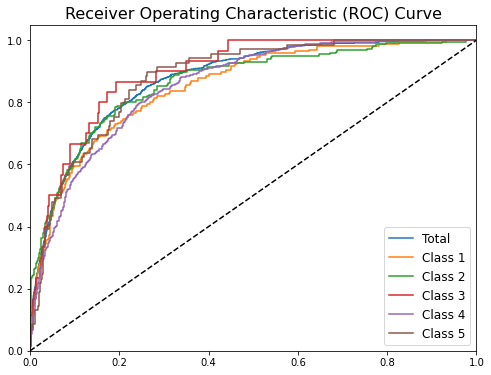

In [161]:
# 根据上面的结果，将所有样本和各类别的结果绘制AUROC，放在一张图上，相互重叠
# 绘制所有样本的ROC曲线
plt.figure(figsize=(8, 6))
fpr_total, tpr_total, thresholds_total = roc_curve(y_true_total, y_pred_total)
plt.plot(fpr_total, tpr_total, label='Total')

# 绘制每个类别的ROC曲线
for cls in set(result['cluster']):
    y_true_cls = result.loc[result['cluster']==cls, 'HOSPITAL_EXPIRE_FLAG_y']
    y_pred_cls = result.loc[result['cluster']==cls, 'PREDICTION']
    fpr_cls, tpr_cls, thresholds_cls = roc_curve(y_true_cls, y_pred_cls)
    plt.plot(fpr_cls, tpr_cls, label='Class {}'.format(cls))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

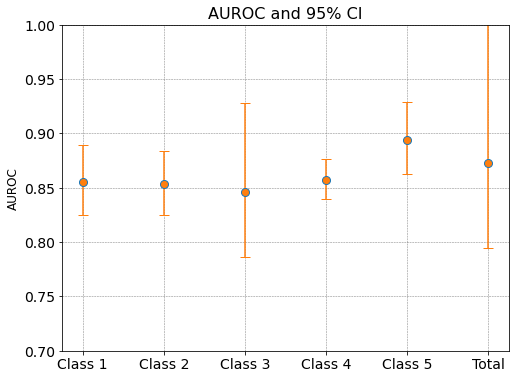

In [135]:
# 不用 errorbar，用其他函数来绘制 我已经计算好的 置信区间
plt.figure(figsize=(8, 6))
plt.plot(['Class 1', 'Class 2', 'Class 3', 'Class 4','Class 5', 'Total'], 
             [auroc_dict[1][0], auroc_dict[2][0], auroc_dict[3][0], auroc_dict[4][0], auroc_dict[5][0],auroc_total], 
             'o', linewidth=2, markersize=8); plt.ylim([0.7, 1.0]); plt.title('AUROC and 95% CI', fontsize=16); plt.ylabel('AUROC', fontsize=12); plt.xticks(fontsize=14); plt.yticks(fontsize=14)
# 还差纵向的置信区间没有画
plt.errorbar(['Class 1', 'Class 2', 'Class 3', 'Class 4','Class 5', 'Total'], 
             [auroc_dict[1][0], auroc_dict[2][0], auroc_dict[3][0], auroc_dict[4][0], auroc_dict[5][0],auroc_total], 
              yerr=np.transpose([(auroc_dict[1][2][1]-auroc_dict[1][0], auroc_dict[1][0]-auroc_dict[1][2][0]), 
                   (auroc_dict[2][2][1]-auroc_dict[2][0], auroc_dict[2][0]-auroc_dict[2][2][0]), 
                   (auroc_dict[3][2][1]-auroc_dict[3][0], auroc_dict[3][0]-auroc_dict[3][2][0]), 
                   (auroc_dict[4][2][1]-auroc_dict[4][0], auroc_dict[4][0]-auroc_dict[4][2][0]), 
                   (auroc_dict[5][2][1]-auroc_dict[5][0], auroc_dict[5][0]-auroc_dict[5][2][0]), 
                   (auroc_ci_total[1]-auroc_total, auroc_total-auroc_ci_total[0])]), 
             fmt='o', capsize=5); plt.ylim([0.7, 1.0]); plt.title('AUROC and 95% CI', fontsize=16); plt.ylabel('AUROC', fontsize=12); plt.xticks(fontsize=14); plt.yticks(fontsize=14); plt.grid(color='gray', linestyle='--', linewidth=0.5); plt.show()

In [288]:
# 写一下accuracy_score
from sklearn.metrics import accuracy_score

In [290]:
result.head()

,HADM_ID,HOSPITAL_EXPIRE_FLAG_x,PREDICTION,HOSPITAL_EXPIRE_FLAG_y,cluster
0,107064,0.0,0.005809,0,2
1,150750,1.0,0.741976,1,2
2,194540,0.0,0.291820,0,4
3,112213,1.0,0.420741,1,2
4,157681,0.0,0.015801,0,2


In [302]:
# 我想计算每个类的准确率
# 初始化一个空字典，用于保存每个类别的真实标签和预测标签
acc_dict = {}

# 对每个类别计算 准确率 ，利用bootstrap法计算标准差和置信区间
# 将每个类的结果保存起来，方便后面绘制准确率的森林图
# 包括total类
for cls in set(result['cluster']):
    y_true_cls = result.loc[result['cluster']==cls, 'HOSPITAL_EXPIRE_FLAG_y']
    y_pred_cls = result.loc[result['cluster']==cls, 'PREDICTION']
    y_pred_cls = np.where(y_pred_cls > 0.5, 1, 0)
    acc_cls = accuracy_score(y_true_cls, y_pred_cls)
    acc_list = []
    for i in range(200):
        resampled = result.loc[result['cluster']==cls].sample(frac=1, replace=True)
        y_true_resampled = resampled['HOSPITAL_EXPIRE_FLAG_y']
        y_pred_resampled = resampled['PREDICTION']
        y_pred_resampled = np.where(y_pred_resampled > 0.5, 1, 0)
        acc_resampled = accuracy_score(y_true_resampled, y_pred_resampled)
        acc_list.append(acc_resampled)
    acc_std_cls = np.std(acc_list)
    acc_ci_cls = np.array([np.mean(acc_list) - 1.96*np.std(acc_list), np.mean(acc_list) + 1.96*np.std(acc_list)])
    print("Class {}, Accuracy 95% CI: {}".format(cls, np.around(acc_ci_cls, 3)))
    print("Class {}, Accuracy: {}".format(cls, np.around(acc_cls, 3)))
    print("Class {}, Accuracy std: {}".format(cls, np.around(acc_std_cls, 3)))
    acc_dict[cls] = [np.around(acc_cls, 3), np.around(acc_std_cls, 3), np.around(acc_ci_cls, 3)]

# 把acc_dict里面的信息转换成 dataframe，第一列是类别，第二列和第四列分别是准确率,标准差和置信区间，注意，类别要包括total
acc_df = pd.DataFrame.from_dict(acc_dict, orient='index', columns=['Accuracy', 'Accuracy std', 'Accuracy 95% CI'])
acc_df.index.name = 'Class'
acc_df.loc['Total'] = [accuracy_score(result['HOSPITAL_EXPIRE_FLAG_y'], np.where(result['PREDICTION'] > 0.5, 1, 0)), 
                       np.std(np.array(acc_list)), 
                       '({:.3f}, {:.3f})'.format(*np.percentile(np.array(acc_list), [2.5, 97.5]))]
print(acc_df)


Class 1, Accuracy 95% CI: [0.773 0.814]
Class 1, Accuracy: 0.793
Class 1, Accuracy std: 0.011
Class 2, Accuracy 95% CI: [0.719 0.753]
Class 2, Accuracy: 0.736
Class 2, Accuracy std: 0.009
Class 3, Accuracy 95% CI: [0.918 0.946]
Class 3, Accuracy: 0.932
Class 3, Accuracy std: 0.007
Class 4, Accuracy 95% CI: [0.856 0.884]
Class 4, Accuracy: 0.87
Class 4, Accuracy std: 0.007
Class 5, Accuracy 95% CI: [0.801 0.853]
Class 5, Accuracy: 0.828
Class 5, Accuracy std: 0.013
       Accuracy  Accuracy std Accuracy 95% CI
Class                                        
1      0.793000      0.011000  [0.773, 0.814]
2      0.736000      0.009000  [0.719, 0.753]
3      0.932000      0.007000  [0.918, 0.946]
4      0.870000      0.007000  [0.856, 0.884]
5      0.828000      0.013000  [0.801, 0.853]
Total  0.818795      0.013118  (0.801, 0.855)


In [303]:
# 把acc_dict里面的信息转换成 dataframe，第一列是类别，第二列和第四列分别是准确率,标准差和置信区间，注意，类别要包括total
acc_df = pd.DataFrame.from_dict(acc_dict, orient='index', columns=['Accuracy', 'Accuracy std', 'Accuracy 95% CI'])
acc_df.index.name = 'Class'
acc_df.loc['Total'] = [accuracy_score(result['HOSPITAL_EXPIRE_FLAG_y'], np.where(result['PREDICTION'] > 0.5, 1, 0)), 
                       np.std(np.array(acc_list)), 
                       '({:.3f}, {:.3f})'.format(*np.percentile(np.array(acc_list), [2.5, 97.5]))]
print(acc_df)

       Accuracy  Accuracy std Accuracy 95% CI
Class                                        
1      0.793000      0.011000  [0.773, 0.814]
2      0.736000      0.009000  [0.719, 0.753]
3      0.932000      0.007000  [0.918, 0.946]
4      0.870000      0.007000  [0.856, 0.884]
5      0.828000      0.013000  [0.801, 0.853]
Total  0.818795      0.013118  (0.801, 0.855)


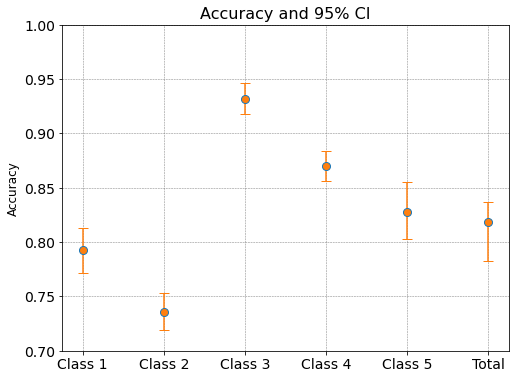

In [304]:

# 仿照上面 auroc，绘制 acc 各类别的置信区间
# 绘制准确率及其置信区间的森林图，用点和线段
# 要横向的，纵坐标范围在0.7到1之间
# 增加一点 grid 线，要灰色的
# 不用 errorbar，用其他函数来绘制 我已经计算好的 置信区间
plt.figure(figsize=(8, 6))
plt.plot(['Class 1', 'Class 2', 'Class 3', 'Class 4','Class 5', 'Total'], 
             [acc_dict[1][0], acc_dict[2][0], acc_dict[3][0], acc_dict[4][0], acc_dict[5][0],accuracy_score(result['HOSPITAL_EXPIRE_FLAG_y'], np.where(result['PREDICTION'] > 0.5, 1, 0))], 
             'o', linewidth=2, markersize=8); plt.ylim([0.7, 1.0]); plt.title('Accuracy and 95% CI', fontsize=16); plt.ylabel('Accuracy', fontsize=12); plt.xticks(fontsize=14); plt.yticks(fontsize=14); 
# 还差纵向的置信区间没有画
plt.errorbar(['Class 1', 'Class 2', 'Class 3', 'Class 4','Class 5', 'Total'], 
             [acc_dict[1][0], acc_dict[2][0], acc_dict[3][0], acc_dict[4][0], acc_dict[5][0],accuracy_score(result['HOSPITAL_EXPIRE_FLAG_y'], np.where(result['PREDICTION'] > 0.5, 1, 0))], 
              yerr=np.transpose([(acc_dict[1][2][1]-acc_dict[1][0], acc_dict[1][0]-acc_dict[1][2][0]), 
                   (acc_dict[2][2][1]-acc_dict[2][0], acc_dict[2][0]-acc_dict[2][2][0]), 
                   (acc_dict[3][2][1]-acc_dict[3][0], acc_dict[3][0]-acc_dict[3][2][0]), 
                   (acc_dict[4][2][1]-acc_dict[4][0], acc_dict[4][0]-acc_dict[4][2][0]), 
                   (acc_dict[5][2][1]-acc_dict[5][0], acc_dict[5][0]-acc_dict[5][2][0]), 
                   (np.percentile(np.array(acc_list), 97.5)-accuracy_score(result['HOSPITAL_EXPIRE_FLAG_y'], np.where(result['PREDICTION'] > 0.5, 1, 0)), 
                    accuracy_score(result['HOSPITAL_EXPIRE_FLAG_y'], np.where(result['PREDICTION'] > 0.5, 1, 0))-np.percentile(np.array(acc_list), 2.5))]), 

             fmt='o', capsize=5); plt.ylim([0.7, 1.0]); plt.title('Accuracy and 95% CI', fontsize=16); plt.ylabel('Accuracy', fontsize=12); plt.xticks(fontsize=14); plt.yticks(fontsize=14); plt.grid(color='gray', linestyle='--', linewidth=0.5); plt.show()
                                

### 可解释性 Integrated gradients

In [267]:
# 获取测试集数据
data_test = CustomData("/home/luojiawei/mimic3_Miss_project/all_admissions/",
                      "/home/luojiawei/mimic3_Miss_project/test.csv")

all_pid 的数量: 16894


In [148]:
# 把 data_test 里面每个样本的 X_dym, X_stc, mask_fea 取出来进行dim=1的拼接,得到X
# 然后将所有样本的X进行 stack,得到(1,time,d) 的张量.
# 注意 每个患者的 X 可能是不同的,如果X.shape[0]大于等于12,那么要 X[:12,],否则对其进行 0 padding
from tqdm import tqdm

In [149]:
X_list = []
mask_list = []
for i in tqdm(range(len(data_test))):
    X_dym, X_stc, mask_fea, time, y, mask = data_test.get_item1(i)
    X = torch.cat([X_dym, X_stc],dim=1)
    # 如果X的行大于等于12,则取前12行,否则对其进行 0 padding
    if X.shape[0] >= 12:
        X = X[:12,:]
    else:
        X = torch.cat([X, torch.zeros((12-X.shape[0], X.shape[1]))], dim=0)
    X_list.append(X)
    mask = torch.cat([torch.ones((X.shape[0],)), torch.zeros((12-X.shape[0],))], dim=0)
    mask_list.append(mask)

X = torch.stack(X_list, dim=0)
mask = torch.stack(mask_list, dim=0)

100%|██████████| 9373/9373 [02:35<00:00, 60.12it/s]


In [153]:
X.shape

torch.Size([9373, 12, 40])

In [154]:
mask.shape

torch.Size([9373, 12])

In [193]:
# 通过集成梯度来计算变量重要度
# 输入是 X
# 注意模型是 LSTM
# 定义一个函数，用于计算变量重要度
def integrated_gradients(inputs, model, baseline=None, steps=50, device=torch.device("cpu")):
    """
    :param inputs: 输入的数据，shape为(batch_size, seq_len, input_size)
    :param model: 预测模型
    :param baseline: 基准值，shape为(seq_len, input_size)，默认为全0
    :param steps: 插值的步数
    :param device: 设备类型
    :return: 变量重要度，shape为(batch_size, seq_len, input_size)
    """
    if baseline is None:
        baseline = torch.zeros_like(inputs[0]).unsqueeze(0)
    else:
        baseline = baseline.unsqueeze(0)
    baseline = baseline.to(device)
    # inputs = inputs.unsqueeze(0)
    # 计算每个步长的插值
    alphas = torch.linspace(0, 1, steps+1).tolist()
    # 计算每个插值对应的输入
    interpolates = [baseline + alpha * (inputs - baseline) for alpha in alphas]
    # 计算每个插值对应的输出
    preds = [model(interpolate.to(device)) for interpolate in interpolates]
    # 计算每个变量的梯度
    grads = []
    for i in range(len(preds)-1):
        grad, = torch.autograd.grad(preds[i+1], inputs, preds[i]-preds[i+1], retain_graph=True)
        grads.append(grad)
    grads = torch.stack(grads, dim=0)
    # 计算变量重要度
    ig = torch.mean(grads, dim=0) * (inputs - baseline)
    return ig.squeeze(0)

In [202]:
device = torch.device("cpu")

In [203]:
model = model.to(device)

In [204]:
X = X.to(device)

In [205]:
X.requires_grad

True

In [206]:
ig = integrated_gradients(X[0:10].to(device),model,steps=10,device=device)

In [208]:
print(ig.shape)

torch.Size([10, 12, 40])


In [ ]:
# 可视化变量重要度
import matplotlib.pyplot as plt
import numpy as np

In [256]:
# 定义一个函数，用于可视化变量重要度
def plot_ig(ig):
    """
    :param ig: 变量重要度，shape为(seq_len, input_size)
    """
    # 将变量重要度按照绝对值从大到小排序
    sorted_idx = np.argsort(np.abs(ig).sum(axis=0))[::-1]
    # 取出前10个变量
    top_k = 10
    sorted_idx = sorted_idx[:top_k]
    # 取出前10个变量的重要度
    top_k_ig = ig[:, sorted_idx]
    # 绘制变量重要度图
    fig, ax = plt.subplots(figsize=(10, 6))
    # print(top_k_ig.shape)
    ax.imshow(top_k_ig, cmap='coolwarm', aspect='auto')
    ax.set_xticks(np.arange(len(sorted_idx)))
    ax.set_xticklabels(sorted_idx, rotation=45, ha='right')
    ax.set_yticks(np.arange(0,top_k_ig.shape[0]))
    ax.set_yticklabels(np.arange(top_k_ig.shape[0]))
    ax.set_xlabel('Features')
    ax.set_ylabel('Time')
    ax.set_title('Variable Importance')
    fig.tight_layout()
    plt.show()

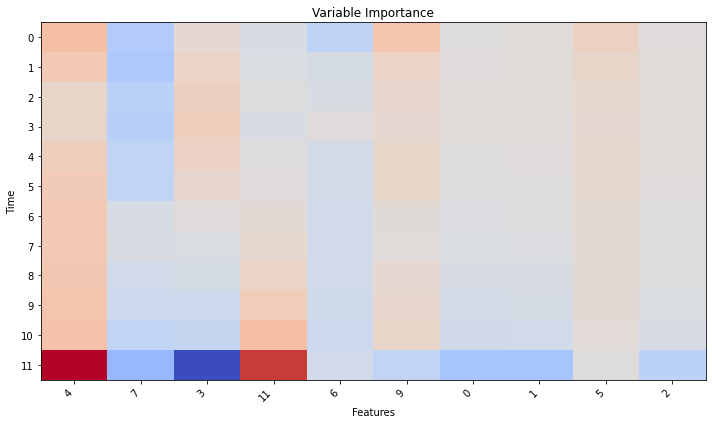

In [258]:
# 可视化变量重要度
plot_ig(ig[8].cpu().detach().data.numpy())